# 02 · Pre-process LUNA16 → 64³ Nodule Patches  
**Purpose** Convert raw LUNA16 CT volumes + physician annotations into
GPU-friendly 64×64×64 voxel cubes, ready for 3-D CNN training.

## Workflow
1. **Mount dataset** – Kaggle auto-mounts `luna16` under `/kaggle/input/…`.
2. **Sanity checks** – count subsets, scans, nodules; inspect HU range.
3. **Helper funcs**  
   * `resample_sitk` → 1 mm³ isotropic voxels  
   * `hu_window` → clip HU to [-1000 , 400] & scale to [0, 1]  
   * `extract_cube` → padding-safe 64³ extraction
4. **Scan lookup** – recursively gather real CT `.mhd` files, ignoring lung-mask `_seg.mhd`, build `ct_paths{SeriesUID:Path}`.
5. **Main loop** – for each annotated nodule  
   * load & resample scan  
   * convert world-coords → voxel-coords  
   * cut 64³ patch and save as `.npy`  
   * log metadata row
6. **Outputs**  
   * `patches_64mm/` – 1 186 patches (≈ 1 MB each)  
   * `patch_index.csv` – filename ↔ SeriesUID ↔ nodule diameter & coords
7. **Next notebooks**  
   * `03_synthetic_profiles.ipynb` – generate tabular risk factors  
   * `04_cnn_baseline.ipynb` – train 3-D ResNet on these patches


In [1]:
from pathlib import Path
import numpy as np, pandas as pd, SimpleITK as sitk
from tqdm import tqdm

RAW_DIR   = Path("/kaggle/input/luna16")          # read-only
WORK_DIR  = Path("/kaggle/working")               # write-able
PATCH_DIR = WORK_DIR / "patches_64mm"
PATCH_DIR.mkdir(exist_ok=True)

### resample_sitk()
Radiology CTs have non-isotropic voxels (e.g., 0.7 mm × 0.7 mm in-plane but 2.5 mm slice thickness). A 3-D CNN works best when voxels are cubes, so we resample:

In [2]:
# Resample to 1 mm³ isotropic
def resample_sitk(image, new_spacing=(1.0, 1.0, 1.0)):
    old_spacing = np.array(image.GetSpacing()[::-1])   # z,y,x
    old_size    = np.array(image.GetSize()[::-1])
    new_size    = (old_spacing * old_size / new_spacing).round().astype(int)
    resample = sitk.ResampleImageFilter()
    resample.SetInterpolator(sitk.sitkLinear)
    resample.SetOutputSpacing(tuple(new_spacing[::-1]))  # x,y,z order
    resample.SetSize([int(s) for s in new_size[::-1]])
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(image.GetOrigin())
    return resample.Execute(image)


### hu_window()
CT values are in Hounsfield Units (HU): air ≈ −1000, lung parenchyma ≈ −800…−400, soft tissue ≈ 0…100, bone 300–3000. We clamp to [−1000, +400] then min-max scale to [0, 1]. Anything denser than soft tissue isn’t informative for nodule parenchyma, and clipping stabilises training.

In [3]:
# HU window & clip to [-1000, 400], normalise to [0,1]
def hu_window(img_arr, hu_min=-1000, hu_max=400):
    img_arr = np.clip(img_arr, hu_min, hu_max)
    return (img_arr - hu_min) / (hu_max - hu_min)


### extract_cube()
Given voxel indices (z,y,x) for the nodule centre: If the nodule is near a lung border, lo can go <0 or hi beyond the scan—so we np.pad with zeros.

In [4]:
# Extract a centered 64³ cube, pad if near edge
def extract_cube(vol, center, size=64):
    z,y,x = center
    r = size // 2
    z1,z2 = z-r, z+r
    y1,y2 = y-r, y+r
    x1,x2 = x-r, x+r
    pad = [[0,0],[0,0],[0,0]]            # for np.pad
    for idx,(lo,hi,dim) in enumerate([(z1,z2,vol.shape[0]),
                                      (y1,y2,vol.shape[1]),
                                      (x1,x2,vol.shape[2])]):
        if lo < 0:
            pad[idx][0] = -lo
            lo = 0
        if hi > dim:
            pad[idx][1] = hi - dim
    cube = vol[max(z1,0):min(z2,vol.shape[0]),
               max(y1,0):min(y2,vol.shape[1]),
               max(x1,0):min(x2,vol.shape[2])]
    if any(pad_i>0 for pair in pad for pad_i in pair):
        cube = np.pad(cube, pad, mode="constant", constant_values=0)
    return cube


In [5]:
# ── rebuild the scan-lookup table ─────────────────────────────
from pathlib import Path
import pandas as pd

RAW_DIR = Path("/kaggle/input/luna16")        # adjust if you renamed it
ann      = pd.read_csv(RAW_DIR / "annotations.csv")
ann_sids = set(ann.seriesuid)                 # 601 scans with nodules

all_mhd  = [p for p in RAW_DIR.rglob("*.mhd")   # recurse any depth
            if "seg" not in p.name.lower()]     # skip lung-mask files

ct_paths = {p.stem: p for p in all_mhd if p.stem in ann_sids}

print("Mapped", len(ct_paths), "scans → path")  # expect ≈ 601
missing = ann_sids - ct_paths.keys()
print("Missing scans:", len(missing))           # should be 0


Mapped 601 scans → path
Missing scans: 0


### Main extraction loop
- Maps the unique SeriesInstanceUID (seriesuid) to the correct .mhd path.
- resample_sitk converts anisotropic CT slices to 1 mm³ cubes; hu_window clamps HU and scales to [0,1] for stable training.
- spacing & origin let us transform physician-annotated world-space millimetres to voxel indices after resampling.
- Each CT can contain multiple nodules → we iterate over its sub-DataFrame df.
- Each 64³ float32 patch (~1 MB) is written as an .npy file named <SeriesUID>_n<i>.npy.
- Parallel “index” row stored in records so we can trace every patch back to its metadata without parsing filenames later.
- The final patch_index.csv plus the patches_64mm/ folder form an easy-to-mount, training-ready dataset.

In [6]:
records = []

for series, df in tqdm(ann.groupby("seriesuid"), desc="scans", total=len(ann_sids)):
    path = ct_paths.get(series)
    if path is None:
        continue

    img_iso  = resample_sitk(sitk.ReadImage(str(path)))
    vol_norm = hu_window(sitk.GetArrayFromImage(img_iso).astype(np.int16))

    spacing  = img_iso.GetSpacing()[::-1]
    origin   = img_iso.GetOrigin()[::-1]

    for idx, row in df.iterrows():
        center = np.round((np.array([row.coordZ, row.coordY, row.coordX]) - origin) / spacing).astype(int)
        patch  = extract_cube(vol_norm, center, 64).astype(np.float32)

        fname  = f"{series}_n{idx}.npy"
        np.save(PATCH_DIR / fname, patch)

        records.append({"patch_file": fname,
                        "seriesuid" : series,
                        "diam_mm"   : row.diameter_mm,
                        "center_x"  : row.coordX,
                        "center_y"  : row.coordY,
                        "center_z"  : row.coordZ})

patch_df = pd.DataFrame(records)
patch_df.to_csv(WORK_DIR / "patch_index.csv", index=False)
print(f"Saved {len(patch_df)} patches to {PATCH_DIR}")


scans: 100%|██████████| 601/601 [12:07<00:00,  1.21s/it]

Saved 1186 patches to /kaggle/working/patches_64mm


(-0.5, 63.5, 63.5, -0.5)

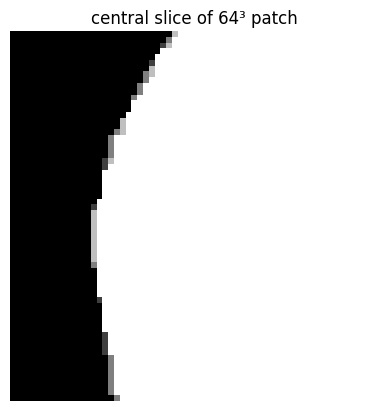

In [7]:
import matplotlib.pyplot as plt
cube = np.load(next(PATCH_DIR.glob("*.npy")))
mid = cube.shape[0]//2
plt.imshow(cube[mid], cmap="gray")
plt.title("central slice of 64³ patch"); plt.axis("off")


In [8]:
# Cell 1 ── imports & seed
import numpy as np, pandas as pd
from pathlib import Path
rng = np.random.default_rng(42)     # reproducible

WORK_DIR = Path("/kaggle/working")
PATCH_IDX = WORK_DIR / "patch_index.csv"   # created in 02_preprocess
patch_df = pd.read_csv(PATCH_IDX)
uids = patch_df["seriesuid"].unique()

# Cell 2 ── define helper samplers
def truncnorm(mean, sd, low, high, n):
    """draw from N(mean,sd) truncated to [low,high]"""
    a = (low - mean) / sd
    b = (high - mean) / sd
    from scipy.stats import truncnorm as tn
    return tn.rvs(a, b, loc=mean, scale=sd, size=n, random_state=rng)

# Cell 3 ── sample each column
n = len(uids)
age  = truncnorm(65, 10, 40, 85, n).round().astype(int)

sex  = rng.choice(["M", "F"], p=[0.55, 0.45], size=n)

smoke = rng.choice(["current", "former", "never"],
                   p=[0.45, 0.40, 0.15], size=n)

pack_years = np.where(
    smoke == "never",
    0,
    rng.gamma(shape=10, scale=3, size=n).round(1)      # mean ≈30 PY
)

yrs_since_quit = np.where(
    smoke == "former",
    rng.integers(1, 31, size=n),     # 1-30 yrs
    0
)

family_hist = rng.choice([0, 1], p=[0.9, 0.1], size=n)
copd       = rng.choice([0, 1], p=[0.8, 0.2], size=n)

# Cell 4 ── assemble DataFrame
profiles = pd.DataFrame({
    "seriesuid"      : uids,
    "age"            : age,
    "sex"            : sex,
    "smoking_status" : smoke,
    "pack_years"     : pack_years,
    "years_since_quit": yrs_since_quit,
    "family_history" : family_hist,
    "copd_dx"        : copd
})

profiles.to_csv(WORK_DIR / "synthetic_profiles.csv", index=False)
print("Done writing synthetic_profiles.csv with", len(profiles), "rows")


Done writing synthetic_profiles.csv with 601 rows
